In [53]:
import pandas as pd
import os
from glob import glob

# 读取基因名称文件
genes_file = '/cluster/home/jialu/genome/gencode.v38.pcg.dedup.tss.bed'
genes_df = pd.read_csv(genes_file, sep='\t', header=None)
genes_df.columns = ['chrm', 'stt', 'end', 'gene', 'length', 'str']

# 获取所有待处理的 .bedpe 文件路径
chip_files_dir = '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/'
chip_files = glob(os.path.join(chip_files_dir, 'filtered*.bedpe'))  # 匹配所有 .bedpe 文件

# 初始化一个 DataFrame 用于存储汇总结果
result_df = genes_df.copy()

# 批量处理每个文件
for chip_file in chip_files:
    # 读取芯片数据文件
    chip_df = pd.read_csv(chip_file, sep='\t', header=None)
    
    # 从文件名中提取 i 值，假设文件名格式为 "filtered_${i}_chip.bedpe"
    file_name = os.path.basename(chip_file)
    i_value = file_name.split('_')[1]  # 根据文件名分割提取 i 值
    
    # 创建一个字典来存储每个基因的出现次数
    gene_count = {}
    for gene in chip_df.iloc[:, 9]:  # 假设第十列是基因名称
        if gene in gene_count:
            gene_count[gene] += 1
        else:
            gene_count[gene] = 1
    
    # 动态新增列，存储基因出现的次数
    count_column_name = f'{i_value}_count'
    hub_column_name = f'{i_value}_hub'
    
    # 将基因出现次数映射到结果 DataFrame
    result_df[count_column_name] = result_df['gene'].map(gene_count).fillna(0).astype(int)
    
    # 根据基因出现次数，判断为 hub 还是 non-hub
    result_df[hub_column_name] = result_df[count_column_name].apply(lambda x: 'HiC hub' if x >= 2 else ('HiC non-hub' if x == 1 else 'non-HiC'))

# 保存结果到新文件
output_file = os.path.join(chip_files_dir, 'avgprofile_hub_summary.bed')
result_df.to_csv(output_file, sep='\t', header=True, index=False)

print("Processing complete. The summarized output file is saved as:", output_file)


Processing complete. The summarized output file is saved as: /cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/avgprofile_hub_summary.bed


/tmp/ipykernel_14117/2187463974.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hub_boundaries = boundaries[hub_status == 'hub']
/tmp/ipykernel_14117/2187463974.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_hub_boundaries = boundaries[hub_status == 'non-hub']  # 提取non-hub基因的边界


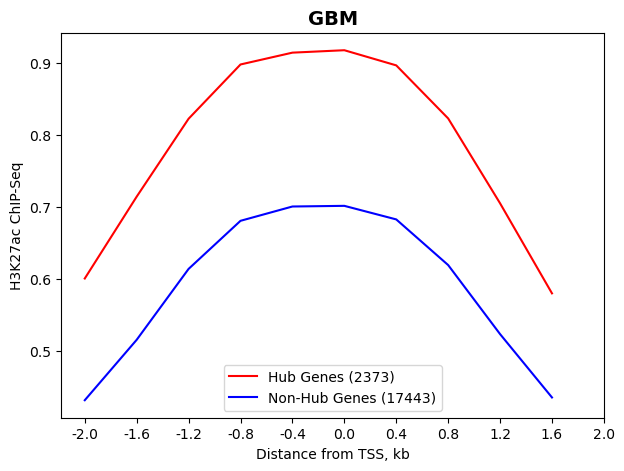

In [ ]:
import pandas as pd
import bbi
import matplotlib.pyplot as plt
import numpy as np

# 文件路径
ctcf_peak_file = '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/GBM.merge_BS_detail.bw'
file_path = '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/avgprofile_hub_summary.bed'

# 读取BED文件
CTCF_boundaries_conserve = pd.read_csv(file_path, sep='\t', header=0)

# 提取需要的列（前三列为染色体、起始位置、结束位置，8列为hub/non-hub信息）
flank = 2000
nbins = 10
cell = 'GBM'
boundaries = CTCF_boundaries_conserve.iloc[:, 0:3].drop_duplicates()
boundaries.columns = ['chrom', 'start', 'end']

# 提取第8列的数据（hub/non-hub）
hub_status = CTCF_boundaries_conserve['GBM_hub']

# 过滤只保留1-22和X染色体
valid_chromosomes = [f'chr{i}' for i in range(1, 23)] + ['chrX']
boundaries = boundaries[boundaries['chrom'].isin(valid_chromosomes)]

# 提取hub基因的边界（即TSS）
hub_boundaries = boundaries[hub_status == 'hub']
non_hub_boundaries = boundaries[hub_status == 'non-hub']  # 提取non-hub基因的边界

# 获取CTCF峰值的数据（stackup），只保留1-22和X染色体
stackup_hub = bbi.stackup(
    ctcf_peak_file,
    hub_boundaries.chrom,
    hub_boundaries.start - flank,
    hub_boundaries.start + flank,
    bins=nbins,
)

stackup_non_hub = bbi.stackup(
    ctcf_peak_file,
    non_hub_boundaries.chrom,
    non_hub_boundaries.start - flank,
    non_hub_boundaries.start + flank,
    bins=nbins,
)

# 创建图形
f, ax = plt.subplots(figsize=[7, 5])

# 对所有hub基因TSS位置的CTCF信号取平均（可以做一个平均图）
ax.plot(np.nanmean(stackup_hub, axis=0), label=f'Hub Genes ({len(hub_boundaries)})', color='red')  # 红色表示hub基因
ax.plot(np.nanmean(stackup_non_hub, axis=0), label=f'Non-Hub Genes ({len(non_hub_boundaries)})', color='blue')  # 蓝色表示non-hub基因

# 设置图形的标签和标题
ax.set(
    xticks=np.arange(0, nbins + 1, 1),  # 可以调整间隔为1
    xticklabels=(np.arange(0, nbins + 1, 1) - nbins // 2) * flank * 2 / nbins / 1000,  # 计算每个bin的大小（单位为kb）
    xlabel='Distance from TSS, kb',
    ylabel='H3K27ac ChIP-Seq',
)

# 设置标题为 GBM
ax.set_title('GBM', fontsize=14, fontweight='bold')

# 添加图例
ax.legend()

# 显示图形
plt.show()

# 如果需要保存图形，取消注释以下行
# f.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/insul_futing/CTCF_{cell}_10k_with_hub_and_nonhub_TSS.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)


/tmp/ipykernel_14117/1166996142.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hub_boundaries = boundaries[hub_status == 'HiC hub']
/tmp/ipykernel_14117/1166996142.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_hub_boundaries = boundaries[hub_status == 'HiC non-hub']
/tmp/ipykernel_14117/1166996142.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nonHIC_boundaries = boundaries[hub_status == 'non-HiC']
/tmp/ipykernel_14117/1166996142.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hub_boundaries = boundaries[hub_status == 'HiC hub']
/tmp/ipykernel_14117/1166996142.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_hub_boundaries = boundaries[hub_status == 'HiC non-hub']
/tmp/ipykernel_14117/1166996142.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nonHIC_boundar

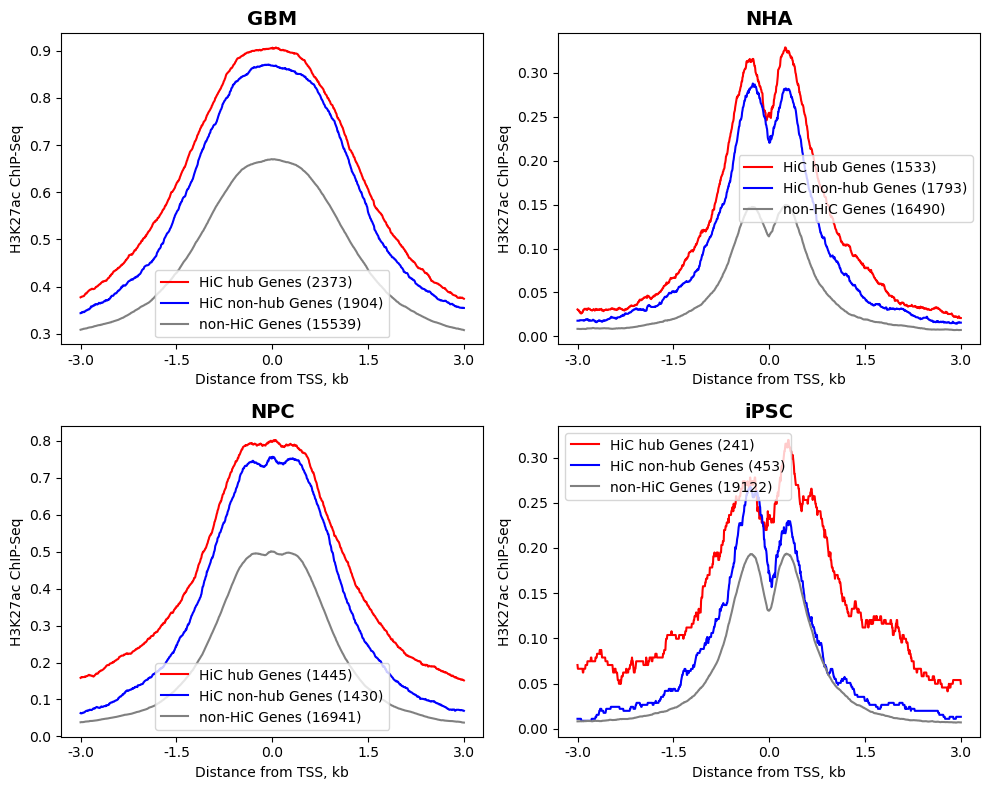

In [68]:
import pandas as pd
import bbi
import matplotlib.pyplot as plt
import numpy as np

# 文件路径模板
ctcf_peak_files = {
    'GBM': '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/GBM.merge_BS_detail.bw',
    'NHA': '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/NHA.merge_BS_detail.bw',
    'NPC': '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/NPC.merge_BS_detail.bw',
    'iPSC': '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/iPSC.merge_BS_detail.bw'
}

# 创建一个2x2的子图
fig, axes = plt.subplots(2, 2, figsize=[10, 8])

# 设置染色体过滤
valid_chromosomes = [f'chr{i}' for i in range(1, 23)] + ['chrX']

# 循环处理每个数据集
for idx, (cell, ctcf_peak_file) in enumerate(ctcf_peak_files.items()):
    # 读取BED文件
    file_path = f'/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/avgprofile_hub_summary.bed'
    CTCF_boundaries_conserve = pd.read_csv(file_path, sep='\t', header=0)

    # 提取需要的列
    flank = 3000
    nbins = 1000
    boundaries = CTCF_boundaries_conserve.iloc[:, 0:3].drop_duplicates()
    boundaries.columns = ['chrom', 'start', 'end']

    # 提取 hub/non-hub 列
    hub_status = CTCF_boundaries_conserve[f'{cell}_hub']  # 根据cell变量选择正确的列

    # 过滤染色体
    boundaries = boundaries[boundaries['chrom'].isin(valid_chromosomes)]

    # 提取hub和non-hub基因的边界
    hub_boundaries = boundaries[hub_status == 'HiC hub']
    non_hub_boundaries = boundaries[hub_status == 'HiC non-hub']
    nonHIC_boundaries = boundaries[hub_status == 'non-HiC']

    # 获取CTCF峰值数据（stackup）
    stackup_hub = bbi.stackup(
        ctcf_peak_file,
        hub_boundaries.chrom,
        hub_boundaries.start - flank,
        hub_boundaries.start + flank,
        bins=nbins,
    )

    stackup_non_hub = bbi.stackup(
        ctcf_peak_file,
        non_hub_boundaries.chrom,
        non_hub_boundaries.start - flank,
        non_hub_boundaries.start + flank,
        bins=nbins,
    )

    stackup_nonHIC = bbi.stackup(
        ctcf_peak_file,
        nonHIC_boundaries.chrom,
        nonHIC_boundaries.start - flank,
        nonHIC_boundaries.start + flank,
        bins=nbins,
    )
    # 选择当前子图位置
    ax = axes[idx // 2, idx % 2]  # 计算当前的子图位置

    # 对所有hub基因TSS位置的CTCF信号取平均
    ax.plot(np.nanmean(stackup_hub, axis=0), label=f'HiC hub Genes ({len(hub_boundaries)})', color='red')  # 红色表示hub基因
    ax.plot(np.nanmean(stackup_non_hub, axis=0), label=f'HiC non-hub Genes ({len(non_hub_boundaries)})', color='blue')  # 蓝色表示non-hub基因
    ax.plot(np.nanmean(stackup_nonHIC, axis=0), label=f'non-HiC Genes ({len(nonHIC_boundaries)})', color='grey')

    # 设置图形的标签和标题
    xticks_positions = np.linspace(0, nbins, 5, dtype=int)  # 选择5个显示的位置
    xticklabels_values = (xticks_positions - nbins // 2) * flank * 2 / nbins / 1000  # 计算对应的标签值（单位为kb）

    ax.set(
        xticks=xticks_positions,  # 只显示这些位置
        xticklabels=xticklabels_values,  # 设置对应的标签
        xlabel='Distance from TSS, kb',
        ylabel='H3K27ac ChIP-Seq',
    )

    # 设置X轴字体大小
    ax.tick_params(axis='x', labelsize=10)

    # 设置标题为当前的cell类型
    ax.set_title(cell, fontsize=14, fontweight='bold')

    # 添加图例
    ax.legend()

# 调整布局，防止重叠
plt.tight_layout()

# 显示图形
plt.show()

# 如果需要保存图形，可以取消注释以下行
# f.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/insul_futing/CTCF_all_cells_10k_with_hub_and_nonhub_TSS.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)


/tmp/ipykernel_16353/540843335.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hub_boundaries = boundaries[hub_status == 'HiC hub']
/tmp/ipykernel_16353/540843335.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_hub_boundaries = boundaries[hub_status == 'HiC non-hub']
/tmp/ipykernel_16353/540843335.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nonHIC_boundaries = boundaries[hub_status == 'non-HiC']
/tmp/ipykernel_16353/540843335.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hub_boundaries = boundaries[hub_status == 'HiC hub']
/tmp/ipykernel_16353/540843335.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_hub_boundaries = boundaries[hub_status == 'HiC non-hub']
/tmp/ipykernel_16353/540843335.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nonHIC_boundaries = 

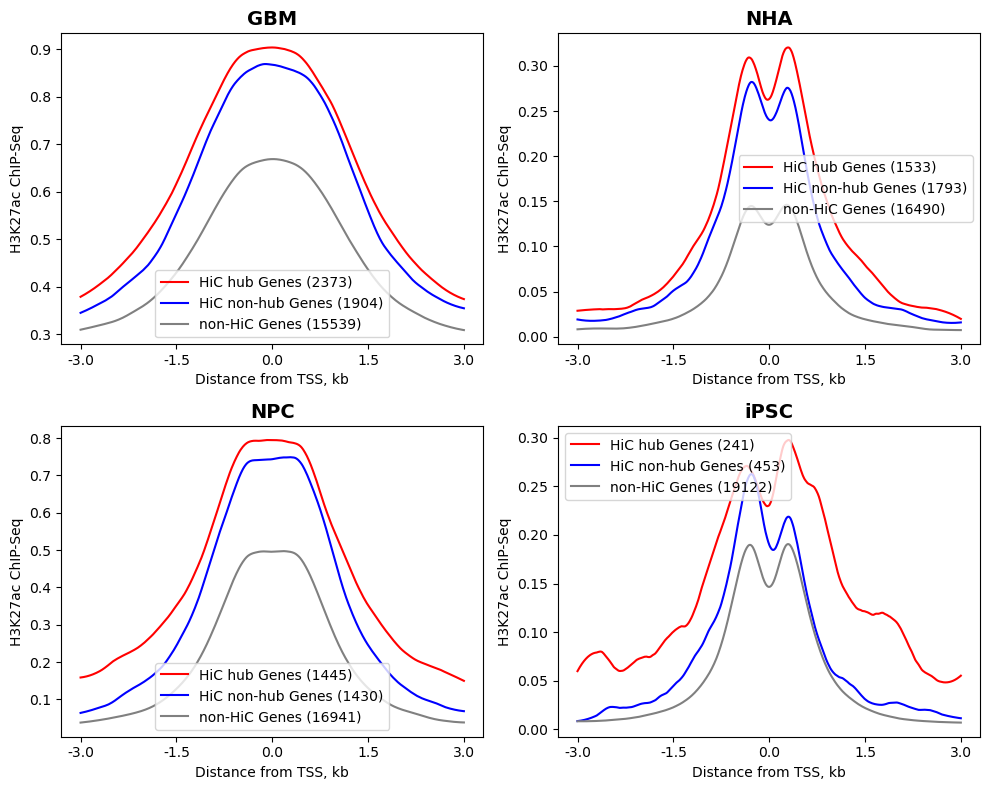

In [3]:
import pandas as pd
import bbi
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter  # 导入Savitzky-Golay滤波器

# 文件路径模板
ctcf_peak_files = {
    'GBM': '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/GBM.merge_BS_detail.bw',
    'NHA': '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/NHA.merge_BS_detail.bw',
    'NPC': '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/NPC.merge_BS_detail.bw',
    'iPSC': '/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/iPSC.merge_BS_detail.bw'
}

# 创建一个2x2的子图
fig, axes = plt.subplots(2, 2, figsize=[10, 8])

# 设置染色体过滤
valid_chromosomes = [f'chr{i}' for i in range(1, 23)] + ['chrX']

# 循环处理每个数据集
for idx, (cell, ctcf_peak_file) in enumerate(ctcf_peak_files.items()):
    # 读取BED文件
    file_path = f'/cluster/home/tmp/GBM/HiC/hubgene/new/chip/addID/avgprofile_hub_summary.bed'
    CTCF_boundaries_conserve = pd.read_csv(file_path, sep='\t', header=0)

    # 提取需要的列
    flank = 3000
    nbins = 1000
    boundaries = CTCF_boundaries_conserve.iloc[:, 0:3].drop_duplicates()
    boundaries.columns = ['chrom', 'start', 'end']

    # 提取 hub/non-hub 列
    hub_status = CTCF_boundaries_conserve[f'{cell}_hub']  # 根据cell变量选择正确的列

    # 过滤染色体
    boundaries = boundaries[boundaries['chrom'].isin(valid_chromosomes)]

    # 提取hub和non-hub基因的边界
    hub_boundaries = boundaries[hub_status == 'HiC hub']
    non_hub_boundaries = boundaries[hub_status == 'HiC non-hub']
    nonHIC_boundaries = boundaries[hub_status == 'non-HiC']

    # 获取CTCF峰值数据（stackup）
    stackup_hub = bbi.stackup(
        ctcf_peak_file,
        hub_boundaries.chrom,
        hub_boundaries.start - flank,
        hub_boundaries.start + flank,
        bins=nbins,
    )

    stackup_non_hub = bbi.stackup(
        ctcf_peak_file,
        non_hub_boundaries.chrom,
        non_hub_boundaries.start - flank,
        non_hub_boundaries.start + flank,
        bins=nbins,
    )

    stackup_nonHIC = bbi.stackup(
        ctcf_peak_file,
        nonHIC_boundaries.chrom,
        nonHIC_boundaries.start - flank,
        nonHIC_boundaries.start + flank,
        bins=nbins,
    )

    # 对数据进行平滑处理，使用Savitzky-Golay滤波器
    stackup_hub_smoothed = savgol_filter(np.nanmean(stackup_hub, axis=0), window_length=101, polyorder=2)
    stackup_non_hub_smoothed = savgol_filter(np.nanmean(stackup_non_hub, axis=0), window_length=101, polyorder=2)
    stackup_nonHIC_smoothed = savgol_filter(np.nanmean(stackup_nonHIC, axis=0), window_length=101, polyorder=2)

    # 选择当前子图位置
    ax = axes[idx // 2, idx % 2]  # 计算当前的子图位置

    # 对所有hub基因TSS位置的CTCF信号取平均
    ax.plot(stackup_hub_smoothed, label=f'HiC hub Genes ({len(hub_boundaries)})', color='red')  # 红色表示hub基因
    ax.plot(stackup_non_hub_smoothed, label=f'HiC non-hub Genes ({len(non_hub_boundaries)})', color='blue')  # 蓝色表示non-hub基因
    ax.plot(stackup_nonHIC_smoothed, label=f'non-HiC Genes ({len(nonHIC_boundaries)})', color='grey')

    # 设置图形的标签和标题
    xticks_positions = np.linspace(0, nbins, 5, dtype=int)  # 选择5个显示的位置
    xticklabels_values = (xticks_positions - nbins // 2) * flank * 2 / nbins / 1000  # 计算对应的标签值（单位为kb）

    ax.set(
        xticks=xticks_positions,  # 只显示这些位置
        xticklabels=xticklabels_values,  # 设置对应的标签
        xlabel='Distance from TSS, kb',
        ylabel='H3K27ac ChIP-Seq',
    )

    # 设置X轴字体大小
    ax.tick_params(axis='x', labelsize=10)

    # 设置标题为当前的cell类型
    ax.set_title(cell, fontsize=14, fontweight='bold')

    # 添加图例
    ax.legend()

# 调整布局，防止重叠
plt.tight_layout()

# 如果需要保存图形，可以取消注释以下行
plt.savefig(f'/cluster/home/tmp/GBM/HiC/hubgene/new/avg_profile/H3k27ac_avg_profile_hub.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()